In [158]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants
import pandas as pd

from scipy.optimize import curve_fit
from scipy.stats import poisson
from scipy import signal
from tqdm.notebook import tqdm
from scipy.constants import Planck, c, elementary_charge
from readTrc import Trc

# Specify path to your files

In [159]:
#choose data
data_dir                = './Lito2 E20/1540nm 32dB 43mK 8p104uA/'
channels                = ['C1']

#The path to your TXT file.
data_nofilter_1540      = './Lito2 E20/1540nm 32dB 43mK 8p104uA/F1--XX-Lito2_E20_43mK_8p104uA_nofilter_1540nm_32dB--00000.txt'
data_nofilter_850       = './Lito2 E20/F1--Lito2_E20_43mK_8p104uA_nofilter_850nm--00000.txt'
data_nofilter_406       = './Lito2 E20/F1--Lito2_E20_43mK_8p104uA_nofilter_406nm--00000.txt'
data_nofilter_1540_24db = './Lito2 E20/F1--XX-Lito2_E20_43mK_8p104uA_nofilter_1540nm_24dB--00000.txt'

# Extract traces

In [160]:
# Load the data per channel
filenames           = {channel: [file for file in os.listdir(data_dir) if channel in file] for channel in channels}
# Dont forget to sort them so that coincidences will match up correctly
for channel in channels:
    filenames[channel]=np.sort(filenames[channel])
    
# Load the data
trc_loader          = Trc()   # Create a loader object
traces              = {channel: [trc_loader.open(os.path.join(data_dir,filename)) for filename in filenames[channel]] for channel in channels}

# Create arrays of events and their time
events              = []
events_time         = [] # not used for analysis, but could be helpful for plotting events
# Since some traces have different lenghts we need to trim them
for j in range(0, len(traces['C1'])):
    if len(traces['C1'][j][1]) == 2502000:
        for i in range(0, (len(traces['C1'][j][1]) // 2502)):
            events.append(traces['C1'][j][1][ 1 + i*2502: (i+1)*2502 - 1])
            events_time.append(traces['C1'][j][0][1+ i*2502: (i+1)*2502 - 1])
    else:
        for i in range(0, (len(traces['C1'][j][1]) // 2501)):
            events.append(traces['C1'][j][1][ 1 + i*2501: (i+1)*2501])
            events_time.append(traces['C1'][j][0][ 1 + i*2501: (i+1)*2501])
print(len(events)) # check how many events we have

51000


# Filter the data

In [161]:
# Sosfilter the signal data
sos             =   signal.butter(2,1/15, output='sos')
butterybiscuits = signal.sosfilt(sos, events)
data = np.array(butterybiscuits) #np.array(events)

# Find the amplitude of the signal minus the baseline
baseline = np.mean(data[:, :250], axis=1)
min = np.min(data[:, 250:250*3], axis=1)
amp = baseline-min

# Create a histogram object
hist, bin_edges = np.histogram(amp, bins=500, range=(-0.01, 0.09))

# Find bin centers
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_centers = np.array(bin_centers, dtype=object)

# Store the corresponding values for each bin
bin_values = []
for i in range(len(bin_centers)):
    # Get the values in each bin
    values_in_bin = len(amp[(amp >= bin_edges[i]) & (amp < bin_edges[i + 1])])
    bin_values.append(values_in_bin)
# bin_values is now a list of arrays, where each array contains the values in a bin


# Histogram filtered

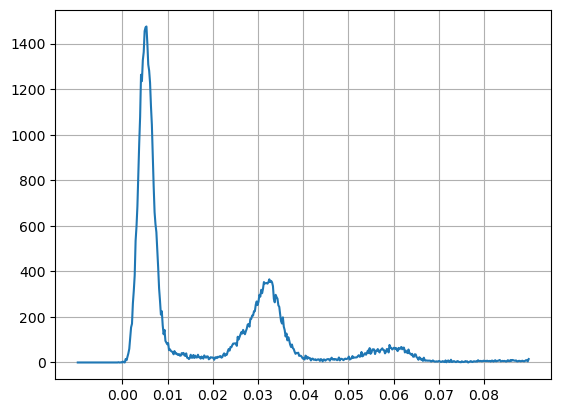

In [162]:
# Optionally, you can convert bin_values to a NumPy array if needed
bin_values = np.array(bin_values, dtype=object)
# Plot a graph of a histogram 
x=bin_centers
y=bin_values
plt.figure()
plt.plot(x,y)
plt.grid()
plt.xticks(np.arange(0, 0.09, step=0.01))
plt.show()

# Multigaussian fit for filtered data

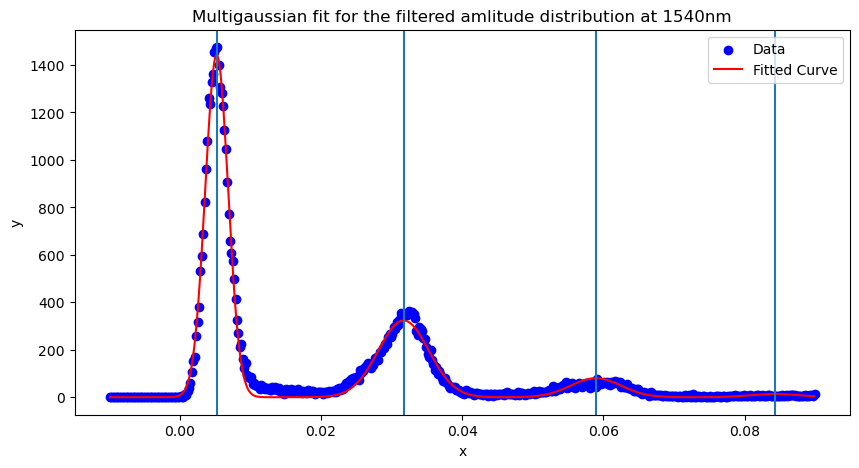

A: 9.63741198145947
mu: 0.49630927512788214
x0: 0.0052086609492063085
x1: 0.03168548755779094
x2: 0.058929722255426586
x3: 0.08433337393278444
s0: 0.0016222606397450717
s: 0.003592513076453233


In [163]:
# Define the function as the sum of multiple Gaussian distributions
def fgauss(x, A, mu, x0, x1, x2, x3, s0, s):
    return A * np.exp(-mu) / np.sqrt(2 * np.pi) * (
        np.exp(-(x - x0) ** 2 / (2 * s0 ** 2)) / s0 +
        mu * np.exp(-(x - x1) ** 2 / (2 * s ** 2)) / s +
        mu ** 2 / 2 * np.exp(-(x - x2) ** 2 / (2 * s ** 2)) / s +
        mu ** 3 / 6 * np.exp(-(x - x3) ** 2 / (2 * s ** 2)) / s
    )

# Initial guesses for parameters (A, mu, x0, x1, x2, x3, s0, s)
initial_guesses = (19, 0.6, 0.005, 0.04, 0.058, 0.085, 0.005, 0.003)


# Fit the curve to your data
params, covariance = curve_fit(fgauss, x, y, p0=initial_guesses, maxfev=10000)

# The optimized parameters are in 'params'
A_fit, mu_fit, x0_fit, x1_fit, x2_fit, x3_fit, s0_fit, s_fit = params

# Generate data points for the fitted curve
x_curve = np.linspace(np.min(x), max(x), 1000)
y_curve = fgauss(x_curve, *params)

# Create a plot
plt.figure(figsize=(10, 5))
plt.scatter(x, y, label='Data', color='b')
plt.plot(x_curve, y_curve, label='Fitted Curve', color='r')
plt.axvline(x0_fit)
plt.axvline(x1_fit)
plt.axvline(x2_fit)
plt.axvline(x3_fit)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Multigaussian fit for the filtered amlitude distribution at 1540nm')

# Show the plot
plt.show()

# Print the optimized parameters
print(f"A: {A_fit}")
print(f"mu: {mu_fit}")
print(f"x0: {x0_fit}")
print(f"x1: {x1_fit}")
print(f"x2: {x2_fit}")
print(f"x3: {x3_fit}")
print(f"s0: {s0_fit}")
print(f"s: {s_fit}")

# Analyse the data from the oscilloscope (1540nm high attenuation)

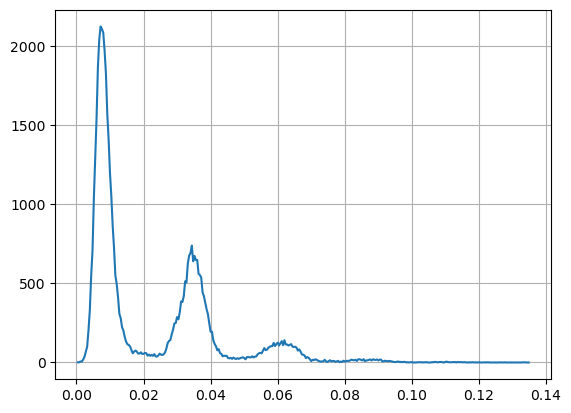

In [164]:
# Read the TXT file into a pandas DataFrame, specifying the delimiter and skipping the first 5 rows.
df = pd.read_csv(data_nofilter_1540, delimiter=',', skiprows=5)  # Change '\t' to the actual delimiter used in your file
data = np.array(df)

# Take only positive amplitudes
data = np.array(df[df.iloc[:, 0]>0])

x_1540=data[:, 0]
y_1540=data[:, 1]

plt.plot(x_1540,y_1540)
plt.grid()
plt.show()


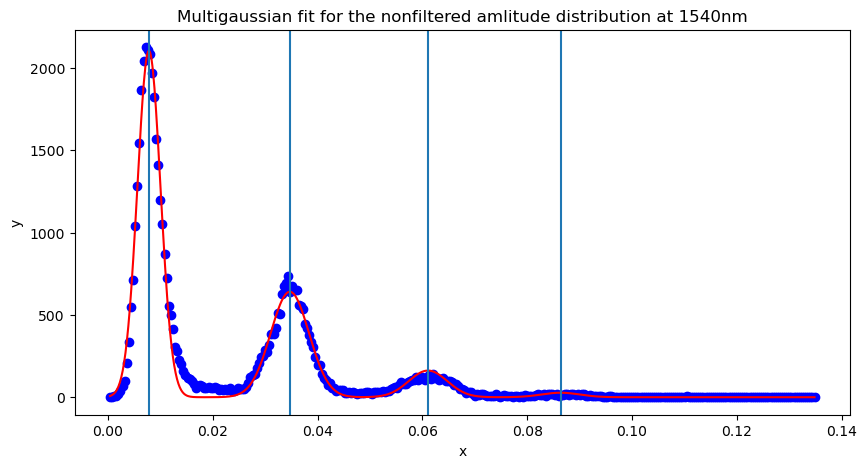

A: 19.302074096027578
mu: 0.5057108521949585
x0: 0.007825557996995263
x1: 0.034705970480805357
x2: 0.06106114453391413
x3: 0.08635126156615612
s0: 0.002207280305836893
s: 0.0036681060165889515


In [173]:
# Initial guesses for parameters (A, mu, x0, x1, x2, x3, s0, s)
initial_guesses_old = (25.0, 0.5, 0.005, 0.032, 0.06, 0.085, 0.005, 0.007)


# Fit the curve to your data
params_1540, covariance = curve_fit(fgauss, x_1540, y_1540, p0=initial_guesses_old, maxfev=10000)

# The optimized parameters are in 'params'
A_fit_old, mu_fit_old, x0_fit_old, x1_fit_old, x2_fit_old, x3_fit_old, s0_fit_old, s_fit_old = params_1540

# Generate data points for the fitted curve
x_curve = np.linspace(np.min(x_1540), max(x_1540), 1000)
y_curve = fgauss(x_curve, *params_1540)

# Create a plot
plt.figure(figsize=(10, 5))
plt.scatter(x_1540, y_1540, label='Nonfiltered 1540', color='b')
plt.plot(x_curve, y_curve, label='Fitted Curve', color='r')
plt.axvline(x0_fit_old)
plt.axvline(x1_fit_old)
plt.axvline(x2_fit_old)
plt.axvline(x3_fit_old)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Multigaussian fit for the nonfiltered amlitude distribution at 1540nm')

# Show the plot
plt.show()

# Print the optimized parameters
print(f"A: {A_fit_old}")
print(f"mu: {mu_fit_old}")
print(f"x0: {x0_fit_old}")
print(f"x1: {x1_fit_old}")
print(f"x2: {x2_fit_old}")
print(f"x3: {x3_fit_old}")
print(f"s0: {s0_fit_old}")
print(f"s: {s_fit_old}")


# Analyse the data from the oscilloscope (1540nm low attenuation)

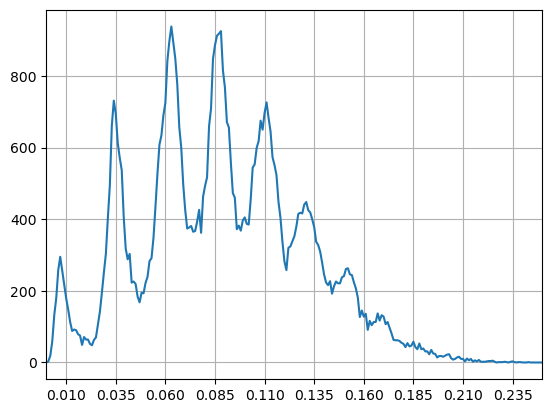

In [166]:
# Read the TXT file into a pandas DataFrame, specifying the delimiter and skipping the first 5 rows.
df_1540_24db = pd.read_csv(data_nofilter_1540_24db, delimiter=',', skiprows=5)  # Change '\t' to the actual delimiter used in your file
data_1540_24db = np.array(df_1540_24db)

# Take only positive amplitudes
data = np.array(df_1540_24db[df_1540_24db.iloc[:, 0]>0])

x_1540_24db=data[:, 0]
y_1540_24db=data[:, 1]

plt.plot(x_1540_24db,y_1540_24db)
plt.xlim(0, 0.25)
plt.xticks(np.arange(0.01, 0.25, 0.025))
plt.grid()
plt.show()

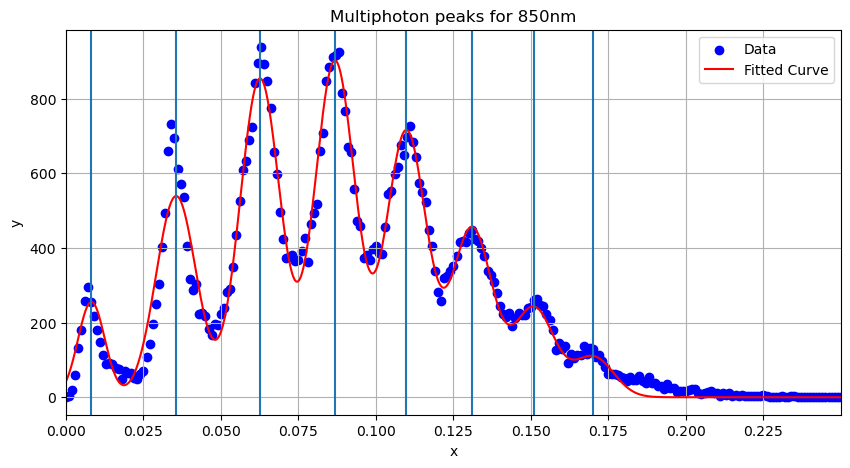

A: 65.69248792675445
mu: 3.1655169641276926
x0: 0.008229314115493939
x1: 0.03555747940471891
x2: 0.06260273197410374
x3: 0.08678122252184035
x4: 0.10980275981243819
x5: 0.1310319515173842
x6: 0.15098657023263284
x7: 0.17013292155574203
s0: 0.004329724168375914
s: 0.006492592963959191


In [167]:
# Define your new function for more Gaussian distributed peaks
def fgauss_1540_24db(x, A, mu, x0, x1, x2, x3, x4, x5, x6, x7, s0, s):
    return A * np.exp(-mu) / np.sqrt(2 * np.pi) * (
                                         np.exp(-(x - x0) ** 2 / (2 * s0 ** 2))/ s0+
        mu *                             np.exp(-(x - x1) ** 2 / (2 * s ** 2)) / s +
        mu ** 2 / np.math.factorial(2) * np.exp(-(x - x2) ** 2 / (2 * s ** 2)) / s +
        mu ** 3 / np.math.factorial(3) * np.exp(-(x - x3) ** 2 / (2 * s ** 2)) / s +
        mu ** 4 / np.math.factorial(4) * np.exp(-(x - x4) ** 2 / (2 * s ** 2)) / s +
        mu ** 5 / np.math.factorial(5) * np.exp(-(x - x5) ** 2 / (2 * s ** 2)) / s +
        mu ** 6 / np.math.factorial(6) * np.exp(-(x - x6) ** 2 / (2 * s ** 2)) / s +
        mu ** 7 / np.math.factorial(7) * np.exp(-(x - x7) ** 2 / (2 * s ** 2)) / s
        )

# Initial guesses for parameters (A, mu, x0, x1, x2, x3, s0, s)
initial_guesses_850 = (73, 3, 0.008, 0.0345, 0.065, 0.087, 0.11, 0.13, 0.15, 0.17, 0.0048, 0.009)

# Fit the curve to your data
params_1540_24db, covariance_1540_24db = curve_fit(fgauss_1540_24db, x_1540_24db, y_1540_24db, p0=initial_guesses_850, maxfev=20000)

# The optimized parameters are in 'params'
A_fit_1540_24db, mu_fit_1540_24db, x0_fit_1540_24db, x1_fit_1540_24db, x2_fit_1540_24db, x3_fit_1540_24db, x4_fit_1540_24db, x5_fit_1540_24db, x6_fit_1540_24db, x7_fit_1540_24db, s0_fit_1540_24db, s_fit_1540_24db = params_1540_24db

# Generate data points for the fitted curve
x_curve = np.linspace(np.min(x_1540_24db), max(x_1540_24db), 10000)
y_curve = fgauss_1540_24db(x_curve, *params_1540_24db)
# Create a plot
plt.figure(figsize=(10, 5))
plt.scatter(x_1540_24db, y_1540_24db, label='Data', color='b')
plt.plot(x_curve, y_curve, label='Fitted Curve', color='r')
plt.axvline(x0_fit_1540_24db)
plt.axvline(x1_fit_1540_24db)
plt.axvline(x2_fit_1540_24db)
plt.axvline(x3_fit_1540_24db)
plt.axvline(x4_fit_1540_24db)
plt.axvline(x5_fit_1540_24db)
plt.axvline(x6_fit_1540_24db)
plt.axvline(x7_fit_1540_24db)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.title('Multiphoton peaks for 850nm')

# Show the plot
plt.xlim(0, 0.25)
plt.xticks(np.arange(0, 0.25, 0.025))
plt.show()

# Print the optimized parameters
print(f"A: {A_fit_1540_24db}")
print(f"mu: {mu_fit_1540_24db}")
print(f"x0: {x0_fit_1540_24db}")
print(f"x1: {x1_fit_1540_24db}")
print(f"x2: {x2_fit_1540_24db}")
print(f"x3: {x3_fit_1540_24db}")
print(f"x4: {x4_fit_1540_24db}")
print(f"x5: {x5_fit_1540_24db}")
print(f"x6: {x6_fit_1540_24db}")
print(f"x7: {x7_fit_1540_24db}")
print(f"s0: {s0_fit_1540_24db}")
print(f"s: {s_fit_1540_24db}")

# Analyse the data from the oscilloscope (850nm)

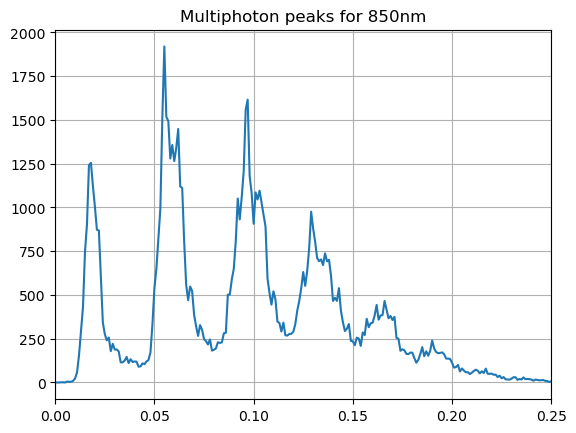

In [168]:

# Read the TXT file into a pandas DataFrame, specifying the delimiter and skipping the first 5 rows.
df_850 = pd.read_csv(data_nofilter_850, delimiter=',', skiprows=5)
data = np.array(df_850)
# Take only positive amplitudes
data = np.array(df_850[df_850.iloc[:, 0]>0])

x_850=data[:, 0]
y_850=data[:, 1]

plt.plot(x_850,y_850)
plt.xlim(0, 0.25)
plt.grid(True)
plt.title('Multiphoton peaks for 850nm')
plt.show()

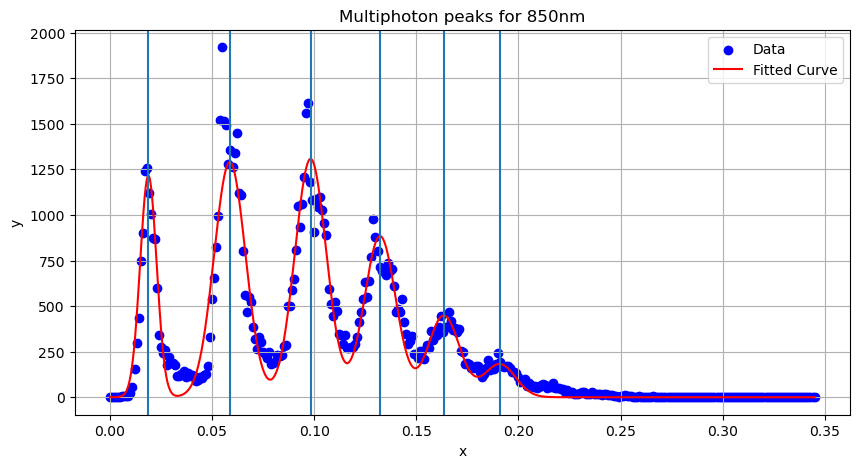

A: 93.29743760161931
mu: 2.0278701882627774
x0: 0.018785260515081437
x1: 0.05866567352058582
x2: 0.09821724130376708
x3: 0.13223903957084077
x4: 0.16343499464114988
x5: 0.19082370109782631
s0: 0.004031113649702337
s: 0.00770271558944122


In [169]:
# Define your new function for more Gaussian distributed peaks
def fgauss_850(x, A, mu, x0, x1, x2, x3, x4, x5, s0, s):
    return A * np.exp(-mu) / np.sqrt(2 * np.pi) * (
                                         np.exp(-(x - x0) ** 2 / (2 * s0 ** 2))/ s0+
        mu *                             np.exp(-(x - x1) ** 2 / (2 * s ** 2)) / s +
        mu ** 2 / np.math.factorial(2) * np.exp(-(x - x2) ** 2 / (2 * s ** 2)) / s +
        mu ** 3 / np.math.factorial(3) * np.exp(-(x - x3) ** 2 / (2 * s ** 2)) / s +
        mu ** 4 / np.math.factorial(4) * np.exp(-(x - x4) ** 2 / (2 * s ** 2)) / s +
        mu ** 5 / np.math.factorial(5) * np.exp(-(x - x5) ** 2 / (2 * s ** 2)) / s
        )

# Initial guesses for parameters (A, mu, x0, x1, x2, x3, s0, s)
initial_guesses_850 = (100, 2.6, 0.02, 0.06, 0.1, 0.13, 0.17,0.19, 0.0048, 0.009)

# Fit the curve to your data
params_850, covariance_850 = curve_fit(fgauss_850, x_850, y_850, p0=initial_guesses_850, maxfev=20000)

# The optimized parameters are in 'params'
A_fit_850, mu_fit_850, x0_fit_850, x1_fit_850, x2_fit_850, x3_fit_850, x4_fit_850, x5_fit_850, s0_fit_850, s_fit_850 = params_850

# Generate data points for the fitted curve
x_curve = np.linspace(np.min(x_850), max(x_850), 10000)
y_curve = fgauss_850(x_curve, *params_850)
# Create a plot
plt.figure(figsize=(10, 5))
plt.scatter(x_850, y_850, label='Data', color='b')
plt.plot(x_curve, y_curve, label='Fitted Curve', color='r')
plt.axvline(x0_fit_850)
plt.axvline(x1_fit_850)
plt.axvline(x2_fit_850)
plt.axvline(x3_fit_850)
plt.axvline(x4_fit_850)
plt.axvline(x5_fit_850)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.title('Multiphoton peaks for 850nm')

# Show the plot
plt.show()

# Print the optimized parameters
print(f"A: {A_fit_850}")
print(f"mu: {mu_fit_850}")
print(f"x0: {x0_fit_850}")
print(f"x1: {x1_fit_850}")
print(f"x2: {x2_fit_850}")
print(f"x3: {x3_fit_850}")
print(f"x4: {x4_fit_850}")
print(f"x5: {x5_fit_850}")
print(f"s0: {s0_fit_850}")
print(f"s: {s_fit_850}")

# Analyse the data from the oscilloscope (406nm)

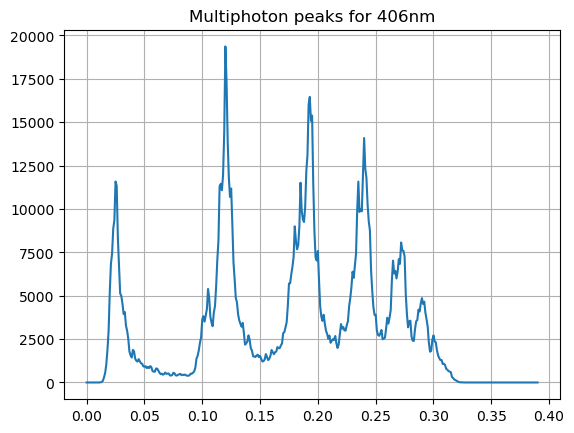

In [170]:
# Read the TXT file into a pandas DataFrame, specifying the delimiter and skipping the first 5 rows.
df_406 = pd.read_csv(data_nofilter_406, delimiter=',', skiprows=5)
data = np.array(df_406)

data = np.array(df_406[df_406.iloc[:, 0]>0])

x_406=data[:, 0]
y_406=data[:, 1]

plt.plot(x_406,y_406)
plt.grid(True)
plt.title('Multiphoton peaks for 406nm')
plt.show()

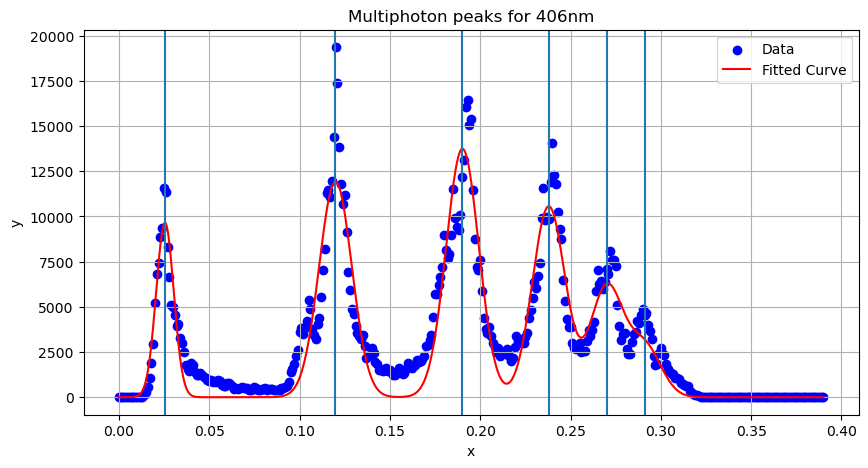

A: 1177.6081557663294
mu: 2.3035765176423104
x0: 0.02550864897056807
x1: 0.11989372668960803
x2: 0.19019121422033242
x3: 0.237933853591079
x4: 0.26997147709901453
x5: 0.291
s0: 0.0048621613270422295
s: 0.00905916604788934


In [171]:
# Define your function
def fgauss_406(x, A, mu, x0, x1, x2, x3, x4, s0, s):
    return A * np.exp(-mu) / np.sqrt(2 * np.pi) * (
                                         np.exp(-(x - x0) ** 2 / (2 * s0 ** 2))/ s0+
        mu *                             np.exp(-(x - x1) ** 2 / (2 * s ** 2)) / s +
        mu ** 2 / np.math.factorial(2) * np.exp(-(x - x2) ** 2 / (2 * s ** 2)) / s +
        mu ** 3 / np.math.factorial(3) * np.exp(-(x - x3) ** 2 / (2 * s ** 2)) / s +
        mu ** 4 / np.math.factorial(4) * np.exp(-(x - x4) ** 2 / (2 * s ** 2)) / s +
        mu ** 5 / np.math.factorial(5) * np.exp(-(x - 0.291) ** 2 / (2 * s ** 2)) / s
        )

# Initial guesses for parameters (A, mu, x0, x1, x2, x3, s0, s)
initial_guesses_406 = (1100, 2.5, 0.023, 0.10, 0.16, 0.21, 0.245, 0.0048, 0.009)


# Fit the curve to your data
params_406, covariance_406 = curve_fit(fgauss_406, x_406, y_406, p0=initial_guesses_406, maxfev=20000)

# The optimized parameters are in 'params'
A_fit_406, mu_fit_406, x0_fit_406, x1_fit_406, x2_fit_406, x3_fit_406, x4_fit_406, s0_fit_406, s_fit_406 = params_406

# Generate data points for the fitted curve
x_curve = np.linspace(np.min(x_406), max(x_406), 10000)
y_curve = fgauss_406(x_curve, *params_406)
x5_fit_406 = 0.291
# Create a plot
plt.figure(figsize=(10, 5))
plt.scatter(x_406, y_406, label='Data', color='b')
plt.plot(x_curve, y_curve, label='Fitted Curve', color='r')
plt.axvline(x0_fit_406)
plt.axvline(x1_fit_406)
plt.axvline(x2_fit_406)
plt.axvline(x3_fit_406)
plt.axvline(x4_fit_406)
plt.axvline(x5_fit_406)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.title('Multiphoton peaks for 406nm')

# Show the plot
plt.show()

# Print the optimized parameters
print(f"A: {A_fit_406}")
print(f"mu: {mu_fit_406}")
print(f"x0: {x0_fit_406}")
print(f"x1: {x1_fit_406}")
print(f"x2: {x2_fit_406}")
print(f"x3: {x3_fit_406}")
print(f"x4: {x4_fit_406}")
print(f"x5: {x5_fit_406}")
print(f"s0: {s0_fit_406}")
print(f"s: {s_fit_406}")

# Make a plot for calibration

[ 5.22992800e+03 -2.71172187e+03  5.48649926e+02 -1.09075275e+01
  6.70245857e-01]


<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 640x480 with 0 Axes>

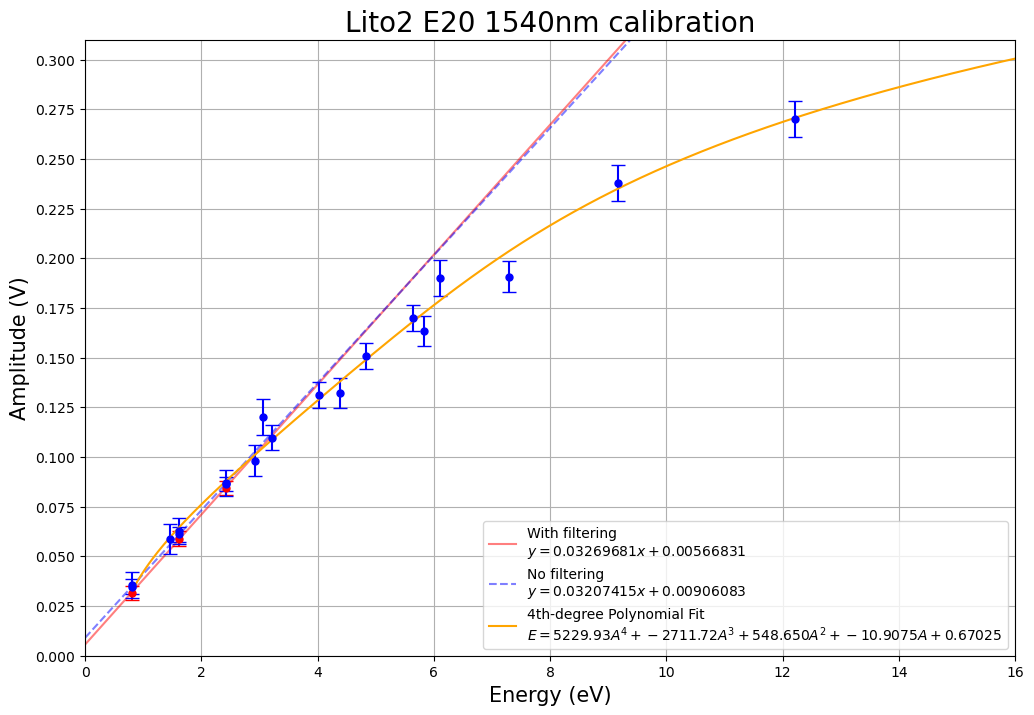

In [172]:
# Define a function to convert photon energy to eV
def energy(E):
    energy = Planck*c/(E*10**(-9)*elementary_charge)
    return energy

# Create an array of corresponding energy for each peak
energy_1540 = []
for i in range(1, len(params) - 4):
    energy_1540.append(np.array(energy(1540)*i))

energy_850 = []
for i in range(1, len(params_850) - 4):
    energy_850.append(np.array(energy(850)*i))

energy_406 = []
for i in range(1, len(params_406) - 4):
    energy_406.append(np.array(energy(406)*i))

energy_1540_24db = []
for i in range(1, len(params_1540_24db) - 4):
    energy_1540_24db.append(np.array(energy(1540)*i))

# Specify arbitrary points on the graph for the regression line
x = np.linspace(0, energy_406[-1], 10)

# Add photon peak values to an array
new_cal = np.array(params[3:-2])
old_cal_1540 = np.array(params_1540[3:-2])
old_cal_850 = np.array(params_850[3:-2])
old_cal_406 = np.array(params_406[3:-2])
old_cal_1540_24db = np.array(params_1540_24db[3:-2])

plt.figure()
fig, ax = plt.subplots(figsize = (12,8))
# Plot each amplitude to its corresponding energy with s parameter as its uncertainty
plt.errorbar(energy_1540, new_cal, color="r",yerr=s_fit, fmt='o', markersize=5, capsize=5)
# Fit linear regression through first 3 points
a1, a0 = np.polyfit(energy_1540, new_cal, deg=1)
equation_new = f'y = {a1:.8f}x + {a0:.8f}'
ax.plot(x, a0 + a1 * x, color="r", linestyle='-', alpha=0.5, lw=1.5, label = f'With filtering\n$y = {a1:.8f}x + {a0:.8f}$');

plt.errorbar(energy_1540, old_cal_1540, color="b",yerr=s_fit_old, fmt='o', markersize=5, capsize=5)
b1, b0 = np.polyfit(energy_1540,old_cal_1540, deg=1)
equation_old = f'y = {b1:.8f}x + {b0:.8f}'
ax.plot(x, b0 + b1 * x, color="b", linestyle='--', alpha=0.5, lw=1.5, label = f'No filtering\n$y = {b1:.8f}x + {b0:.8f}$');

plt.errorbar(energy_850, old_cal_850,color="b", yerr=s_fit_850, fmt='o', markersize=5, capsize=5)
plt.errorbar(energy_406, old_cal_406,color="b", yerr=s_fit_406, fmt='o', markersize=5, capsize=5)
plt.errorbar(energy_1540_24db, old_cal_1540_24db,color="b", yerr=s_fit_1540_24db, fmt='o', markersize=5, capsize=5)

energies = np.array(energy_1540 + energy_850 + energy_406 +energy_1540_24db)
amplitudes = np.concatenate([old_cal_1540, old_cal_850, old_cal_406, old_cal_1540_24db])
y_E = np.linspace(np.min(amplitudes), np.max(amplitudes)+0.1, 1000)
cffs = np.polyfit(amplitudes, energies, deg=4)
polynomial = np.poly1d(cffs)
print(cffs)
x_E = polynomial(y_E)

plt.plot(x_E, y_E, label=f'4th-degree Polynomial Fit\n$E = {cffs[0]:.2f}A^4 + {cffs[1]:.2f}A^3 + {cffs[2]:.3f}A^2 + {cffs[3]:.4f}A + {cffs[4]:.5f}$'  , color='orange')
# ax.plot(x_E, c0 + c1*x_E + c2*x_E^2 + c3*x_E^3 + c4*x_E^4, color="k", linestyle='--', alpha=0.5, lw=1.5, label='No filtering');


plt.xlabel('Energy (eV)', fontsize=15)
plt.ylabel('Amplitude (V)', fontsize=15)
plt.legend()
# plt.text(1.1, 0.0898, equation_new, fontsize=12, color='r')
# plt.text(1.1, 0.0865, equation_old, fontsize=12, color='b')
plt.title('Lito2 E20 1540nm calibration', fontsize=20)
plt.ylim(0.02, 0.31)
plt.xlim(0,16)
plt.yticks(np.arange(0, 0.31, 0.025))
plt.grid(True)
plt.show